In [ ]:
# Notebook to analyze with rome and still investgiating the SF frame
# Author Hadi Asghari, v2024-09


# prereq: `datasets transformers torch scikit-learn seaborn`

from rome.causal_trace import ModelAndTokenizer  # Module for running causal traces.
import matplotlib.pyplot as plt

In [ ]:
import torch
torch.set_grad_enabled(False)

model_name = "meta-llama/Meta-Llama-3-8B-Instruct" 
MT = ModelAndTokenizer(model_name)  # use: `huggingface-cli login` to give private token. 

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

DBG: AutoModelForCausalLM( meta-llama/Meta-Llama-3-8B-Instruct ) in 33.1 sec


In [ ]:
# HA's my additional helper functions for debugging (not from ROME paper/repo)

import torch
import torch.nn.functional as F
import warnings

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda")  # CUDA or Apple MPS 

def gen_text(MT, prompt, max_tokens=10, give_top=5):
    generated_text = ""
    input_ids = MT.tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)
    # HA the `generate()` method produces a stupid error regarding temperature being set somewhere...
    #    unclear how to unset it (tried passing temp=None & model.temp=None), so just ignorning the warning
    warnings.filterwarnings("ignore")
    output_ids = MT.model.generate(input_ids, 
                                   do_sample=False, 
                                   max_new_tokens=max_tokens, 
                                   pad_token_id=MT.tokenizer.eos_token_id,
                                   eos_token_id=MT.tokenizer.eos_token_id,
                                   ) # Q: temperature?
    warnings.filterwarnings("default")
    if give_top and give_top>0:
        generated_text += "Top: " + gen_toptokens(MT, prompt, give_top) + "\n"
    generated_text += MT.tokenizer.decode(output_ids[0], skip_special_tokens=True).replace("\n", "  ")
    generated_text += "\n"
    return generated_text


# DIFF METHOD THAT PRODUCES TOP10 TOKEN PREDICTION LIST FOR A MODEL/PROMPT 
def gen_toptokens(MT, prompt, top=5):
    output = ""
    input_ids = MT.tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)    
    with torch.no_grad():
        outputs = MT.model(input_ids)
        predictions = outputs.logits[:, -1, :]  # Take the predictions for the last token
        top_k = torch.topk(predictions, top)  # Get the top k token IDs
        probabilities = F.softmax(predictions, dim=-1)  # softmax conveerts logits to probs
        top_k_ids = top_k.indices[0]
        top_k_probs = probabilities[0][top_k_ids]  # Get the top k probabilities
    
    # Decode and print the top tokens along with their probabilities
    for token_id, prob in zip(top_k_ids, top_k_probs):
        token = MT.tokenizer.decode([token_id.item()])
        output += f"{token} ({prob.item():.1%})  "
    return output


# Tests
print(gen_text(MT, 'In the "strict father" frame, the objective is to'), "\n")
print(gen_text(MT, 'In the "nurturing parent" frame, the objective is to'), "\n")
print(gen_text(MT, 'In the "strict father" frame, misbehavior is met with'), "\n")
print(gen_text(MT, 'In the "nurturing parent" frame, misbehavior is met with'), "\n")

# AUTOCOMPLETES ON LLAMA-3-8B-INSTRUCT:
#  -- interestingly close!
# In the "strict father" frame, the objective is to create a sense of responsibility and accountability in the child
# In the "nurturing parent" frame, the objective is to create a safe and supportive environment that fosters the
# In the "strict father" frame, misbehavior is met with punishment and discipline, while in the "nurt
# In the "nurturing parent" frame, misbehavior is met with empathy and understanding, rather than punishment or discipline.

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Top:  create (7.5%)   teach (6.5%)   make (5.5%)   protect (4.5%)   raise (4.2%)  
In the "strict father" frame, the objective is to create a sense of responsibility and accountability in the child
 

Top:  create (20.9%)   help (17.5%)   provide (10.4%)   support (5.0%)   promote (3.6%)  
In the "nurturing parent" frame, the objective is to create a safe and supportive environment that fosters the
 

Top:  punishment (54.2%)   discipline (14.8%)   strict (8.3%)   swift (7.0%)   firm (1.7%)  
In the "strict father" frame, misbehavior is met with punishment and discipline, while in the "nurt
 

Top:  empathy (81.5%)   understanding (9.7%)   compassion (1.4%)   curiosity (1.0%)   empath (0.8%)  
In the "nurturing parent" frame, misbehavior is met with empathy and understanding, rather than punishment or discipline.
 



In [ ]:
# Plot functions 
from rome.causal_trace import calculate_hidden_flow, plot_trace_heatmap

def plot_flows(
    mt,
    prompt,
    subject,  # HA: word to highlight/trace
    noise,    # HA: default was 0.1, but probably best to change for Llama2=0.041 - Llama3=0.023
    samples=10,
    window=10,
    kind="mix|mlp|attn",
    attn=False,
    modelname=None,
    savepdf=None,
    title=None,
):
    kind = kind.lower()
    assert kind in ("mix", "mlp", "attn", "mix|mlp", "mix|attn", "mlp|attn", "mix|mlp|attn", "attn|mlp") 
    kinds = kind.split("|")
    fig = None
    for kind in kinds:
        kind = None if kind == "mix" else kind
        # The `calculate_hidden_flow` function creates a causal flow heatmap is created by repeating 
        # `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location in a loop.  
        # (It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  
        #  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore 
        #  several layers of contributions at once, which is done by `trace_important_window`.)
        # To obfuscate the subject during Causal Tracing, we use noise (sampled from a zero-centered spherical Gaussian)
        result = calculate_hidden_flow(
            mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
        )  
        fig = plot_trace_heatmap(result, savepdf, modelname=modelname, title=title)
    return fig  # last one


In [ ]:
# HA: Code below in ROME notebook calculates the noise from their dataset
# for LLAMA2: float value is 0.414 (about half the default noise level of 0.1, so we might want to change)
# for LLama3: Using noise level 0.023 

# from experiments.causal_trace import collect_embedding_std  
# from dsets import KnownsDataset   
# from util.globals import DATA_DIR 
# knowns = KnownsDataset(DATA_DIR)  # Their dataset of known facts
# their_noise_level = 3 * collect_embedding_std(MT, [k["subject"] for k in knowns])
# print(f"Using noise level {their_noise_level}") 

In [ ]:
# FIGURES FOR THE PAPER: WE USE LLAMA3 + MIX (will explain mlp/attn parts in paper). store as PDF.  should have no title.

plot_flows(MT, 'In the "strict father" frame, misbehavior is met with', 
           subject="strict father", 
           kind="mix", 
           noise=0.023,
           title="",
           #savepdf="./rom-l3-sf.pdf"
           )  



DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: trace_important_states token_range: range(0, 14) num_layers: 32
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2
DBG: plot_trace_heatmap: 3


In [ ]:
plot_flows(MT, 'In the "nurturing parent" frame, misbehavior is met with', 
           subject="nurturing parent", 
           kind="mix", 
           noise=0.023,
           title="",
           #savepdf="./rom-l3-np.pdf"
           )



DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: trace_important_states token_range: range(0, 16) num_layers: 32
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2
DBG: plot_trace_heatmap: 3


DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: trace_important_states token_range: range(0, 15) num_layers: 32
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2


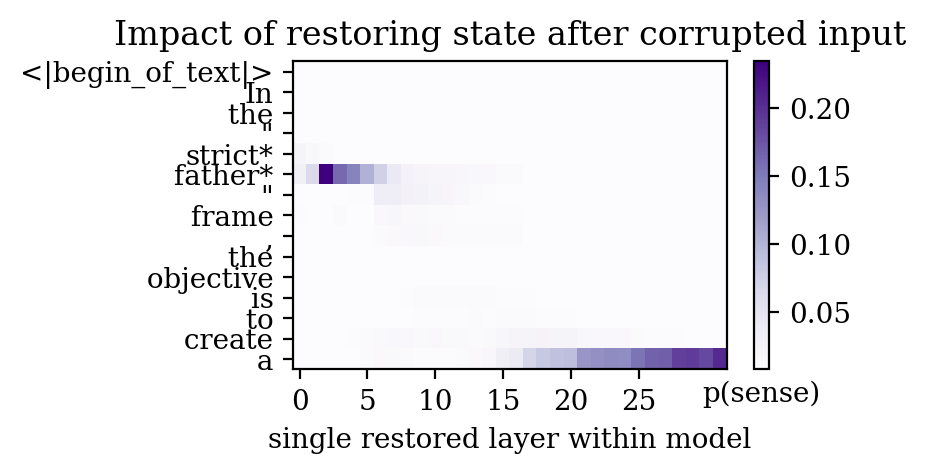

DBG: plot_trace_heatmap: 3
DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2


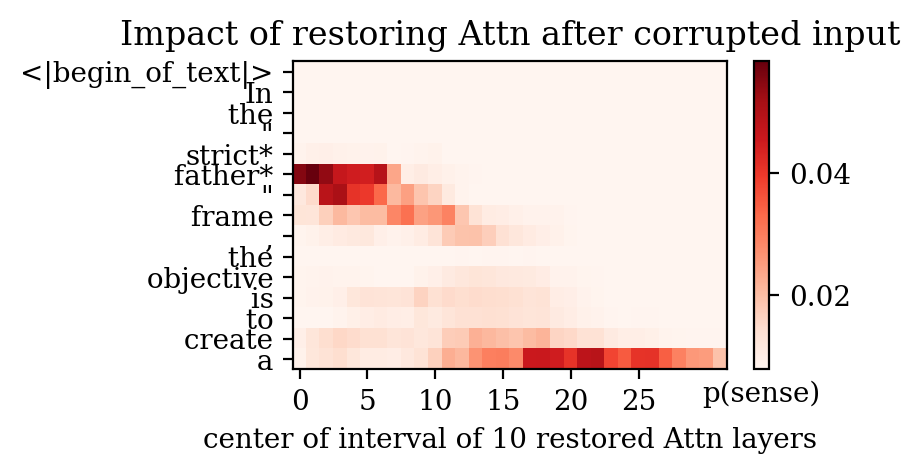

DBG: plot_trace_heatmap: 3


In [ ]:
# REDRAWING FOR LLAMA3

plot_flows(MT, 'In the "strict father" frame, the objective is to create a', 
           subject="strict father", kind="mix|attn", noise=0.025)


DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: trace_important_states token_range: range(0, 17) num_layers: 32
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2


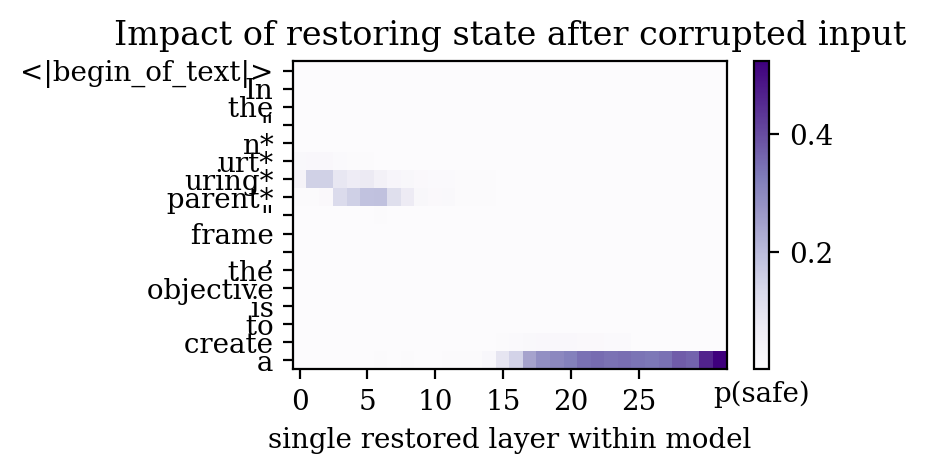

DBG: plot_trace_heatmap: 3
DBG: calculate_hidden_flow: 1
DBG: calculate_hidden_flow: 2 -- slowest
DBG: calculate_hidden_flow: 3
DBG: plot_trace_heatmap: 1
DBG: plot_trace_heatmap: 2


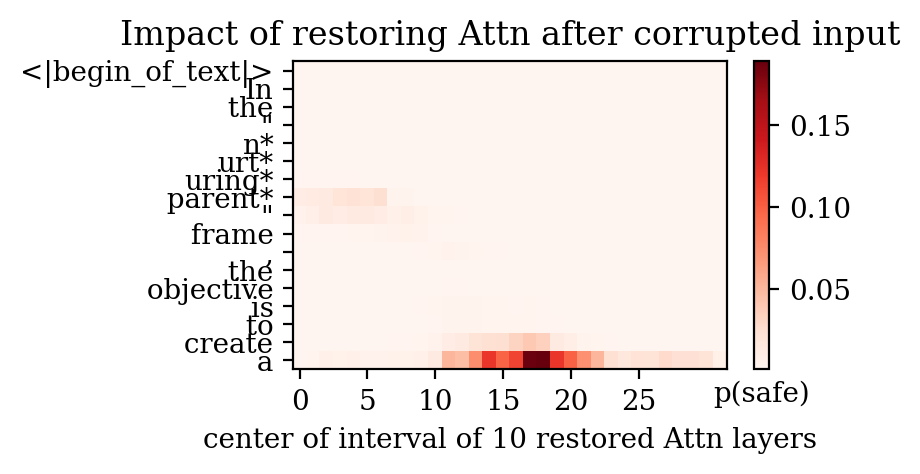

DBG: plot_trace_heatmap: 3


In [ ]:
plot_flows(MT, 'In the "nurturing parent" frame, the objective is to create a', 
           subject="nurturing parent", kind="mix|attn", noise=0.025)
